# CLIP with conformal prediction

Comparing prediciton set size across different datasets

In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
assert torch.cuda.is_available()
import open_clip
from tqdm import tqdm
import wilds

## datasets

In [2]:
data_dir = Path('../data')
cifar_train = datasets.CIFAR100(root=data_dir, train=True)
cifar_test = datasets.CIFAR100(root=data_dir, train=False)

In [3]:
# df = pd.read_csv(data_dir/'tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None)
# words_map = dict(pd.read_csv(data_dir/'tiny-imagenet-200/words.txt', sep='\t', header=None).values)
# all_words = sorted([x if isinstance(x, str) else '#' for x in words_map.values()])
# df.insert(1, 'target', df.iloc[:, 1].map(words_map))
# test_words = sorted(set(df.target.values))
# test_words_map = dict(map(reversed, enumerate(test_words)))
# df.insert(2, 'target_index', df.target.map(test_words_map))
# df.rename(columns={0: 'image'}, inplace=True)

In [4]:
k = 10000
val_data = np.load(data_dir/'Imagenet64_val_npz/val_data.npz')
images = val_data['data'].reshape(-1, 3, 64, 64)
labels = val_data['labels']
subset = np.random.permutation(images.shape[0])[:k]
images = images[subset]
labels = labels[subset]
df = pd.read_csv(data_dir/'map_clsloc.txt', sep=' ', header=None, names=['id', 'index', 'class'])

In [5]:
cifar_classes = tuple(cifar_test.classes)
cifar_class_map = dict(map(reversed, cifar_test.class_to_idx.items()))

In [6]:
class DS(Dataset):
    def __init__(self, images, labels, transforms=None, target_transforms=None):
        assert len(images) == len(labels)
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.target_transforms = target_transforms
        
    def __getitem__(self, k):
        x = self.images[k]
        y = self.labels[k]
        if self.transforms is not None:
            x = self.transforms(x)
        if self.target_transforms is not None:
            y = self.target_transforms(y)
        return x, y
    
    def __len__(self):
        return len(self.images)
    

In [7]:
imagenet_test_dataset = DS(
    images, labels, 
    transforms=transforms.Compose([
        transforms.Lambda(lambda x: np.moveaxis(x, 0, -1)),
        transforms.ToPILImage(),
    ]),
    target_transforms=transforms.Lambda(lambda y: y - 1),
)

In [8]:
cifar_test_dataset = DS(
    cifar_test.data, cifar_test.targets,
    transforms=transforms.Compose([
        # transforms.ToTensor(),
        # transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
        transforms.ToPILImage(),
    ]), 
)

loader_params = dict(batch_size=16, shuffle=False, pin_memory=True, num_workers=8)
cifar_test_loader = DataLoader(cifar_test_dataset, **loader_params)

In [9]:
wild_dataset = wilds.get_dataset(dataset='iwildcam', root_dir=data_dir/'wilds')
wild_test_id = wild_dataset.get_subset('id_test')
wild_test_od = wild_dataset.get_subset('test', frac=0.2)

In [10]:
wild_df = pd.read_csv(wild_dataset._data_dir / 'categories.csv')
wild_class_map = dict(wild_df[['y', 'name']].values)
wild_classes = tuple(wild_class_map.values())

In [11]:
len(wild_test_od), len(wild_test_id)

(8558, 8154)

## CLIP model

In [12]:
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

In [13]:
imagenet_classes = df['class'].values

In [14]:
imagenet_true_class = []
imagenet_pred_class = []
imagenet_pred_scores = []

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in imagenet_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(imagenet_test_dataset))):
        x, y = imagenet_test_dataset[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        imagenet_true_class.append(y)
        imagenet_pred_class.append(scores.argmax().item())
        imagenet_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
imagenet_true_class = np.asarray(imagenet_true_class)
imagenet_pred_class = np.asarray(imagenet_pred_class)
imagenet_pred_scores = np.asarray(imagenet_pred_scores)

imagenet_acc = (imagenet_true_class == imagenet_pred_class).sum() / imagenet_true_class.shape[0]
print(f'imagenet100 accuracy: {imagenet_acc:.1%}')

  3%|▉                              | 303/10000 [00:13<07:14, 22.32it/s]

KeyboardInterrupt



In [11]:
cifar_true_class = []
cifar_pred_class = []
cifar_pred_scores = []

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in cifar_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(cifar_test_dataset))):
        x, y = cifar_test_dataset[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        cifar_true_class.append(y)
        cifar_pred_class.append(scores.argmax().item())
        cifar_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
cifar_true_class = np.asarray(cifar_true_class)
cifar_pred_class = np.asarray(cifar_pred_class)
cifar_pred_scores = np.asarray(cifar_pred_scores)

cifar_acc = (cifar_true_class == cifar_pred_class).sum() / cifar_true_class.shape[0]
print(f'CIFAR100 accuracy: {cifar_acc:.1%}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:52<00:00, 11.20it/s]

CIFAR100 accuracy: 68.6%


In [12]:
wild_id_true_class = []
wild_id_pred_class = []
wild_id_pred_scores = []

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in wild_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(wild_test_id))):
        x, y, _ = wild_test_id[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        wild_id_true_class.append(y)
        wild_id_pred_class.append(scores.argmax().item())
        wild_id_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
wild_id_true_class = np.asarray(wild_id_true_class)
wild_id_pred_class = np.asarray(wild_id_pred_class)
wild_id_pred_scores = np.asarray(wild_id_pred_scores)

wild_od_true_class = []
wild_od_pred_class = []
wild_od_pred_scores = []

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in wild_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(wild_test_id))):
        x, y, _ = wild_test_id[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        wild_od_true_class.append(y)
        wild_od_pred_class.append(scores.argmax().item())
        wild_od_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
wild_od_true_class = np.asarray(wild_od_true_class)
wild_od_pred_class = np.asarray(wild_od_pred_class)
wild_od_pred_scores = np.asarray(wild_od_pred_scores)

wild_id_acc = (wild_id_true_class == wild_id_pred_class).sum() / wild_id_true_class.shape[0]
print(f'WILD ID accuracy: {wild_id_acc:.1%}')
wild_od_acc = (wild_od_true_class == wild_od_pred_class).sum() / wild_od_true_class.shape[0]
print(f'WILD OD accuracy: {wild_od_acc:.1%}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 8154/8154 [15:52<00:00,  8.56it/s]


WILD ID accuracy: 2.2%
WILD OD accuracy: 2.2%


## Conformal prediction

In [17]:
def get_quantile(scores, targets, alpha=0.1):
    n = torch.tensor(targets.size(0))
    score_dist = torch.take_along_dim(1 - scores, targets.unsqueeze(1), 1).flatten()
    qhat = torch.quantile(score_dist, torch.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher")
    return qhat


def make_prediction_sets(scores, qhat, allow_empty_sets=False):
    n = scores.size(0)
    elements_mask = scores >= (1 - qhat)
    if not allow_empty_sets:
        elements_mask[torch.arange(n), scores.argmax(1)] = True
    return elements_mask

def get_coverage(psets, targets, precision=None):
    psets = psets.clone().detach()
    targets = targets.clone().detach()
    n = psets.shape[0]
    coverage = psets[torch.arange(n), targets].float().mean().item()
    if precision is not None:
        coverage = round(coverage, precision)
    return coverage


def get_size(psets, precision=1):
    psets = psets.clone().detach()
    size = psets.sum(1).float().mean().item()
    if precision is not None:
        size = round(size, precision)
    return size


def get_coverage_by_class(psets, targets, num_classes):
    psets = psets.clone().detach()
    targets = targets.clone().detach()
    results = {}
    for c in range(num_classes):
        index = targets == c
        psets_c = psets[index]
        targets_c = targets[index]
        results[c] = get_coverage(psets_c, targets_c)
    return results


def get_efficiency_by_class(psets, targets, num_classes):
    psets = psets.clone().detach()
    targets = targets.clone().detach()
    sizes = psets.sum(1)
    results = {}
    for c in range(num_classes):
        index = targets == c
        psets_c = psets[index]
        results[c] = get_size(psets_c)
    return results


In [147]:
frac = 0.1
alpha = 0.1

imagenet_n = int(round(frac * len(imagenet_pred_scores)))
imagenet_cal_scores = torch.tensor(imagenet_pred_scores[:imagenet_n])
imagenet_cal_targets = torch.tensor(imagenet_true_class[:imagenet_n])
imagenet_val_scores = torch.tensor(imagenet_pred_scores[imagenet_n:])
imagenet_val_targets = torch.tensor(imagenet_true_class[imagenet_n:])

imagenet_qhat = get_quantile(imagenet_cal_scores, imagenet_cal_targets, alpha=alpha)
imagenet_psets = make_prediction_sets(imagenet_val_scores, imagenet_qhat)

print(f'IMAGENET coverage: {get_coverage(imagenet_psets, imagenet_val_targets):.1%}')
print(f'IMAGENET set size: {get_size(imagenet_psets):.1f}')

cifar_n = int(round(frac * len(cifar_pred_scores)))
cifar_cal_scores = torch.tensor(cifar_pred_scores[:cifar_n])
cifar_cal_targets = torch.tensor(cifar_true_class[:cifar_n])
cifar_val_scores = torch.tensor(cifar_pred_scores[cifar_n:])
cifar_val_targets = torch.tensor(cifar_true_class[cifar_n:])

cifar_qhat = get_quantile(cifar_cal_scores, cifar_cal_targets, alpha=alpha)
cifar_psets = make_prediction_sets(cifar_val_scores, cifar_qhat)

print(f'CIFAR100 coverage: {get_coverage(cifar_psets, cifar_val_targets):.1%}')
print(f'CIFAR100 set size: {get_size(cifar_psets):.1f}')

wild_id_n = int(round(frac * len(wild_id_pred_scores)))
wild_id_cal_scores = torch.tensor(wild_id_pred_scores[:wild_id_n])
wild_id_cal_targets = torch.tensor(wild_id_true_class[:wild_id_n])
wild_id_val_scores = torch.tensor(wild_id_pred_scores[wild_id_n:])
wild_id_val_targets = torch.tensor(wild_id_true_class[wild_id_n:])

wild_id_qhat = get_quantile(wild_id_cal_scores, wild_id_cal_targets, alpha=alpha)
wild_id_psets = make_prediction_sets(wild_id_val_scores, wild_id_qhat)

print(f'WILD ID coverage: {get_coverage(wild_id_psets, wild_id_val_targets):.1%}')
print(f'WILD ID set size: {get_size(wild_id_psets):.1f}')

wild_od_n = int(round(frac * len(wild_od_pred_scores)))
wild_od_cal_scores = torch.tensor(wild_od_pred_scores[:wild_od_n])
wild_od_cal_targets = torch.tensor(wild_od_true_class[:wild_od_n])
wild_od_val_scores = torch.tensor(wild_od_pred_scores[wild_od_n:])
wild_od_val_targets = torch.tensor(wild_od_true_class[wild_od_n:])

wild_od_qhat = get_quantile(wild_od_cal_scores, wild_od_cal_targets, alpha=alpha)
wild_od_psets = make_prediction_sets(wild_od_val_scores, wild_od_qhat)

print(f'WILD OD coverage: {get_coverage(wild_od_psets, wild_od_val_targets):.1%}')
print(f'WILD OD set size: {get_size(wild_od_psets):.1f}')

IMAGENET coverage: 91.0%
IMAGENET set size: 42.2
CIFAR100 coverage: 91.0%
CIFAR100 set size: 5.4
WILD ID coverage: 92.1%
WILD ID set size: 163.7
WILD OD coverage: 92.1%
WILD OD set size: 163.7


In [153]:
sizes = [
    cifar_psets.sum(1),
    imagenet_psets.sum(1),
    wild_id_psets.sum(1),
]

In [186]:
wild_classes

('empty',
 'tayassu pecari',
 'dasyprocta punctata',
 'cuniculus paca',
 'puma concolor',
 'tapirus terrestris',
 'pecari tajacu',
 'mazama americana',
 'leopardus pardalis',
 'geotrygon montana',
 'nasua nasua',
 'dasypus novemcinctus',
 'eira barbara',
 'didelphis marsupialis',
 'procyon cancrivorus',
 'panthera onca',
 'myrmecophaga tridactyla',
 'tinamus major',
 'sylvilagus brasiliensis',
 'puma yagouaroundi',
 'leopardus wiedii',
 'mazama gouazoubira',
 'philander opossum',
 'capra aegagrus',
 'bos taurus',
 'ovis aries',
 'canis lupus',
 'lepus saxatilis',
 'papio anubis',
 'genetta genetta',
 'tragelaphus scriptus',
 'herpestes sanguineus',
 'loxodonta africana',
 'cricetomys gambianus',
 'raphicerus campestris',
 'hyaena hyaena',
 'aepyceros melampus',
 'crocuta crocuta',
 'caracal caracal',
 'equus ferus',
 'panthera leo',
 'tragelaphus oryx',
 'kobus ellipsiprymnus',
 'phacochoerus africanus',
 'panthera pardus',
 'ichneumia albicauda',
 'canis mesomelas',
 'syncerus caffer'

([<matplotlib.axis.YTick at 0x7f18e26e3c10>,
 [Text(0, 1, 'CIFAR100'),
  Text(0, 2, 'Mini-ImageNet\n(1000 classes)'),
  Text(0, 3, 'WILDS\niWildCam\n(183 classes)')])

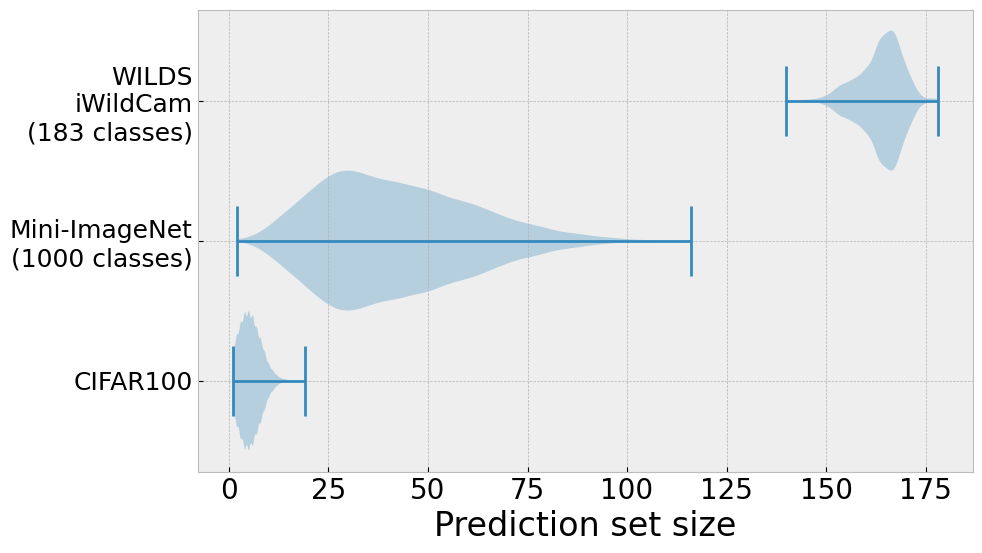

In [185]:
fontsize=24
plt.figure(figsize=(10, 6))
plt.violinplot(sizes, vert=False, widths=1.0)
plt.xlabel('Prediction set size', fontsize=fontsize)
plt.xticks(fontsize=fontsize-4)
plt.yticks(ticks=range(1, 4), labels=[f'CIFAR100', f'Mini-ImageNet\n(1000 classes)', f'WILDS\niWildCam\n({len(wild_classes)} classes)'], fontsize=fontsize-6)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

axs[1, 1].violinplot(data, pos, points=100, vert=False, widths=0.9,
                     showmeans=True, showextrema=True, showmedians=True,
                     bw_method='silverman')
axs[1, 1].set_title('Custom violinplot 7', fontsize=fs)

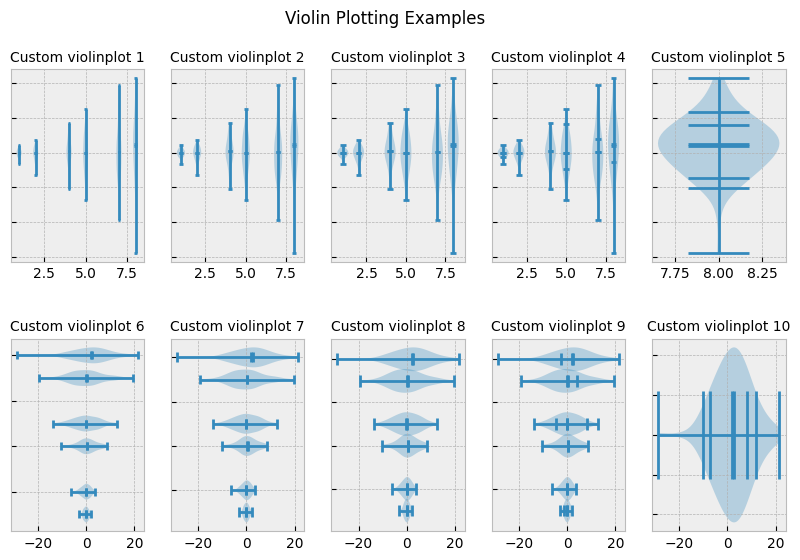

In [19]:
# Fixing random state for reproducibility
np.random.seed(19680801)


# fake data
fs = 10  # fontsize
pos = [1, 2, 4, 5, 7, 8]
data = [np.random.normal(0, std, size=100) for std in pos]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

axs[0, 0].violinplot(data, pos, points=20, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)
axs[0, 0].set_title('Custom violinplot 1', fontsize=fs)

axs[0, 1].violinplot(data, pos, points=40, widths=0.5,
                     showmeans=True, showextrema=True, showmedians=True,
                     bw_method='silverman')
axs[0, 1].set_title('Custom violinplot 2', fontsize=fs)

axs[0, 2].violinplot(data, pos, points=60, widths=0.7, showmeans=True,
                     showextrema=True, showmedians=True, bw_method=0.5)
axs[0, 2].set_title('Custom violinplot 3', fontsize=fs)

axs[0, 3].violinplot(data, pos, points=60, widths=0.7, showmeans=True,
                     showextrema=True, showmedians=True, bw_method=0.5,
                     quantiles=[[0.1], [], [], [0.175, 0.954], [0.75], [0.25]])
axs[0, 3].set_title('Custom violinplot 4', fontsize=fs)

axs[0, 4].violinplot(data[-1:], pos[-1:], points=60, widths=0.7,
                     showmeans=True, showextrema=True, showmedians=True,
                     quantiles=[0.05, 0.1, 0.8, 0.9], bw_method=0.5)
axs[0, 4].set_title('Custom violinplot 5', fontsize=fs)

axs[1, 0].violinplot(data, pos, points=80, vert=False, widths=0.7,
                     showmeans=True, showextrema=True, showmedians=True)
axs[1, 0].set_title('Custom violinplot 6', fontsize=fs)

axs[1, 1].violinplot(data, pos, points=100, vert=False, widths=0.9,
                     showmeans=True, showextrema=True, showmedians=True,
                     bw_method='silverman')
axs[1, 1].set_title('Custom violinplot 7', fontsize=fs)

axs[1, 2].violinplot(data, pos, points=200, vert=False, widths=1.1,
                     showmeans=True, showextrema=True, showmedians=True,
                     bw_method=0.5)
axs[1, 2].set_title('Custom violinplot 8', fontsize=fs)

axs[1, 3].violinplot(data, pos, points=200, vert=False, widths=1.1,
                     showmeans=True, showextrema=True, showmedians=True,
                     quantiles=[[0.1], [], [], [0.175, 0.954], [0.75], [0.25]],
                     bw_method=0.5)
axs[1, 3].set_title('Custom violinplot 9', fontsize=fs)

axs[1, 4].violinplot(data[-1:], pos[-1:], points=200, vert=False, widths=1.1,
                     showmeans=True, showextrema=True, showmedians=True,
                     quantiles=[0.05, 0.1, 0.8, 0.9], bw_method=0.5)
axs[1, 4].set_title('Custom violinplot 10', fontsize=fs)


for ax in axs.flat:
    ax.set_yticklabels([])

fig.suptitle("Violin Plotting Examples")
fig.subplots_adjust(hspace=0.4)
plt.show()